In [23]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cv2
import os

In [24]:
# Load train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [25]:
# Display basic information about the datasets
print("Train Dataset Info:")
print(train_df.info())
print("\nTest Dataset Info:")
print(test_df.info())

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55489 entries, 0 to 55488
Columns: 176 entries, id to X3112_sd
dtypes: float64(54), int64(122)
memory usage: 74.5 MB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13873 entries, 0 to 13872
Columns: 164 entries, id to VOD_X_1997_2018_multiyear_mean_m12
dtypes: float64(42), int64(122)
memory usage: 17.4 MB
None


In [26]:
# Check for missing values in the train DataFrame
train_missing_values = train_df.isnull().sum()
print("Missing values in Train DataFrame:")
print(train_missing_values)

Missing values in Train DataFrame:
id                                                                           0
WORLDCLIM_BIO1_annual_mean_temperature                                       0
WORLDCLIM_BIO12_annual_precipitation                                         0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month        0
WORLDCLIM_BIO15_precipitation_seasonality                                    0
                                                                         ...  
X11_sd                                                                   16341
X18_sd                                                                   16341
X26_sd                                                                   16341
X50_sd                                                                   16341
X3112_sd                                                                 16341
Length: 176, dtype: int64


**There is missing data for the sd values of the target for 29.44% of the dataset. We can create another dataset, where we fill these values, or we can just ignore the sd values.**

In [27]:
# Check for missing values in the test DataFrame
test_missing_values = test_df.isnull().sum()
print("\nMissing values in Test DataFrame:")
print(test_missing_values)


Missing values in Test DataFrame:
id                                                                       0
WORLDCLIM_BIO1_annual_mean_temperature                                   0
WORLDCLIM_BIO12_annual_precipitation                                     0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month    0
WORLDCLIM_BIO15_precipitation_seasonality                                0
                                                                        ..
VOD_X_1997_2018_multiyear_mean_m08                                       0
VOD_X_1997_2018_multiyear_mean_m09                                       0
VOD_X_1997_2018_multiyear_mean_m10                                       0
VOD_X_1997_2018_multiyear_mean_m11                                       0
VOD_X_1997_2018_multiyear_mean_m12                                       0
Length: 164, dtype: int64


array([[<Axes: title={'center': 'X11_mean'}>,
        <Axes: title={'center': 'X18_mean'}>,
        <Axes: title={'center': 'X26_mean'}>],
       [<Axes: title={'center': 'X50_mean'}>,
        <Axes: title={'center': 'X3112_mean'}>,
        <Axes: title={'center': 'X4_sd'}>],
       [<Axes: title={'center': 'X11_sd'}>,
        <Axes: title={'center': 'X18_sd'}>,
        <Axes: title={'center': 'X26_sd'}>],
       [<Axes: title={'center': 'X50_sd'}>,
        <Axes: title={'center': 'X3112_sd'}>, <Axes: >]], dtype=object)

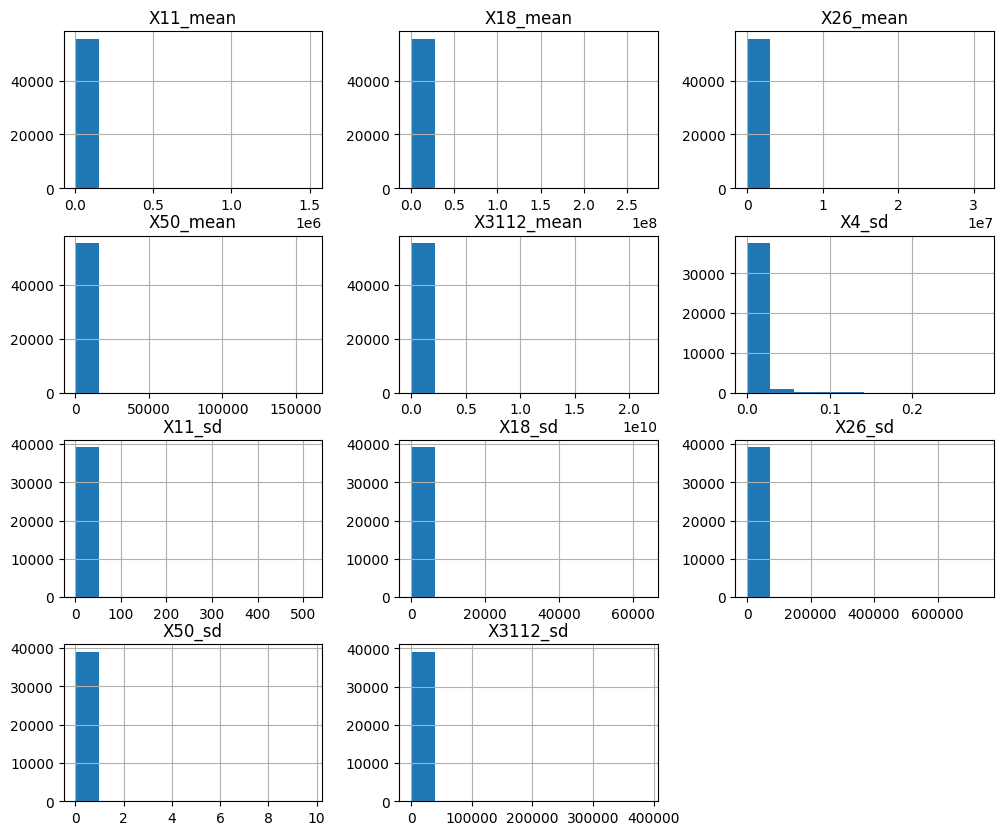

In [28]:
# List of columns to apply log10 transformation
columns_to_log = ['X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean',
                  'X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']

# Visualize the distribution of log-transformed variables in the train DataFrame
train_df[columns_to_log].hist(figsize=(12, 10))

**The target variables don't have a nice distribution, so I use log10 on them**

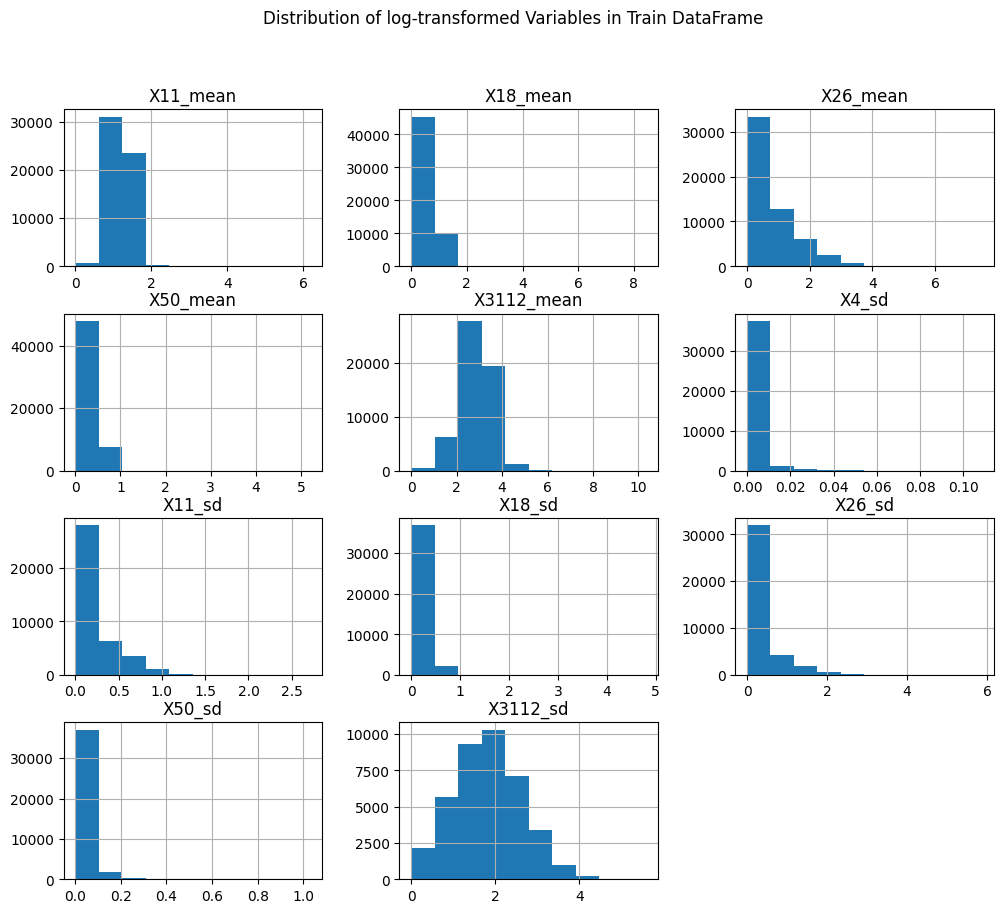

In [29]:
# Apply log10 transformation to the specified columns
for column in columns_to_log:
    train_df[column] = np.log10(train_df[column] + 1)  # Adding 1 to avoid log(0)

# Visualize the distribution of log-transformed variables in the train DataFrame
train_df[columns_to_log].hist(figsize=(12, 10))
plt.suptitle("Distribution of log-transformed Variables in Train DataFrame")
plt.show()

In [30]:
# Define a function to detect outliers using the IQR method
def detect_outliers(df, columns):
    outliers = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers[column] = column_outliers
    return outliers

# List of columns to check for outliers
columns_to_check = train_df.columns

# Detect outliers in every column
outliers = detect_outliers(train_df, columns_to_check)

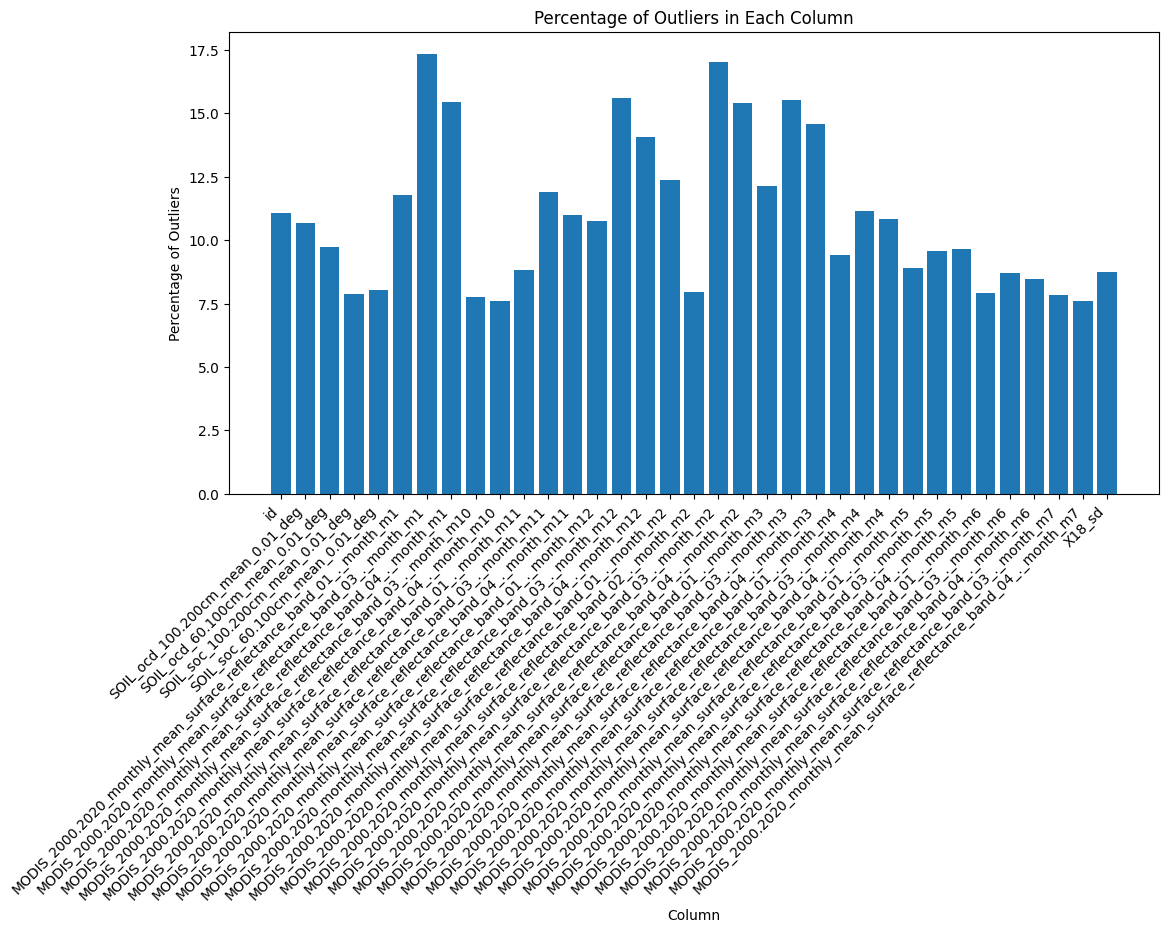

In [31]:
min_percentage = 7.5

# Define a function to calculate the percentage of outliers in each column
def calculate_outlier_percentage(df, outliers):
    outlier_percentages = {}
    total_samples = len(df)
    for column, outlier_df in outliers.items():
        outlier_count = len(outlier_df)
        outlier_percentage = (outlier_count / total_samples) * 100
        if outlier_percentage > min_percentage:
            outlier_percentages[column] = outlier_percentage
    return outlier_percentages

# Calculate the percentage of outliers for each column
outlier_percentages = calculate_outlier_percentage(train_df, outliers)

# Plot a bar chart to visualize the percentage of outliers for each column
plt.figure(figsize=(12, 6))
plt.bar(outlier_percentages.keys(), outlier_percentages.values())
plt.title("Percentage of Outliers in Each Column")
plt.xlabel("Column")
plt.ylabel("Percentage of Outliers")
plt.xticks(rotation=45, ha='right')
plt.show()


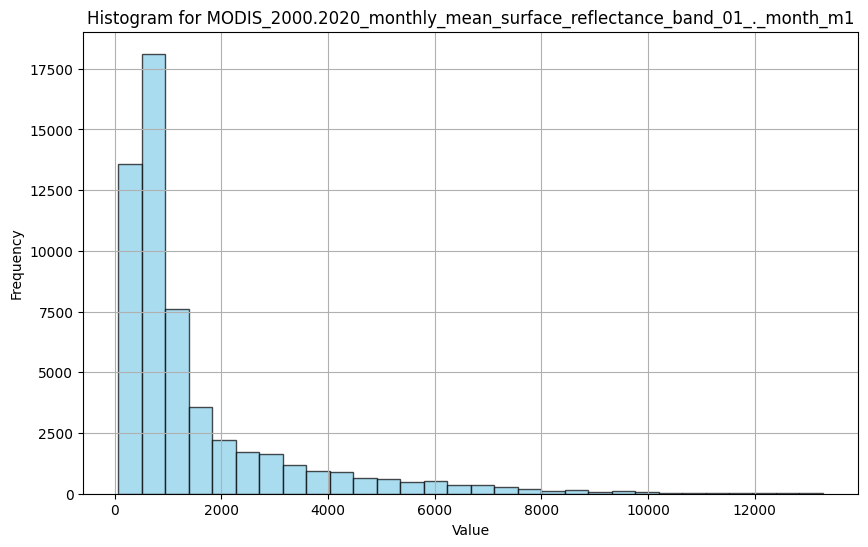

In [39]:
# Specify the column to visualize
column = "MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1"

# Plot a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(train_df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"Histogram for {column}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


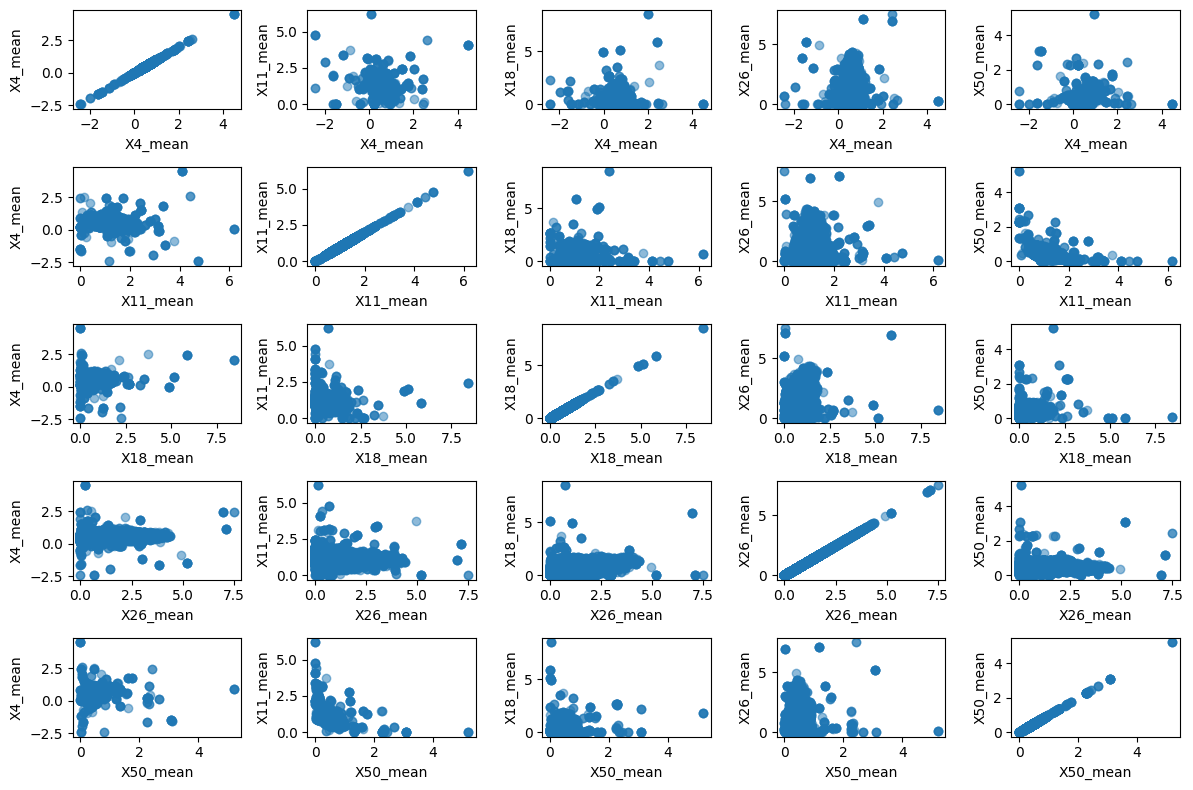

In [41]:
# Specify the columns for joint distribution
columns_for_joint_distribution = ['X4_mean','X11_mean', 'X18_mean', 'X26_mean', 'X50_mean']

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(column1)
        plt.ylabel(column2)
plt.tight_layout()
plt.show()


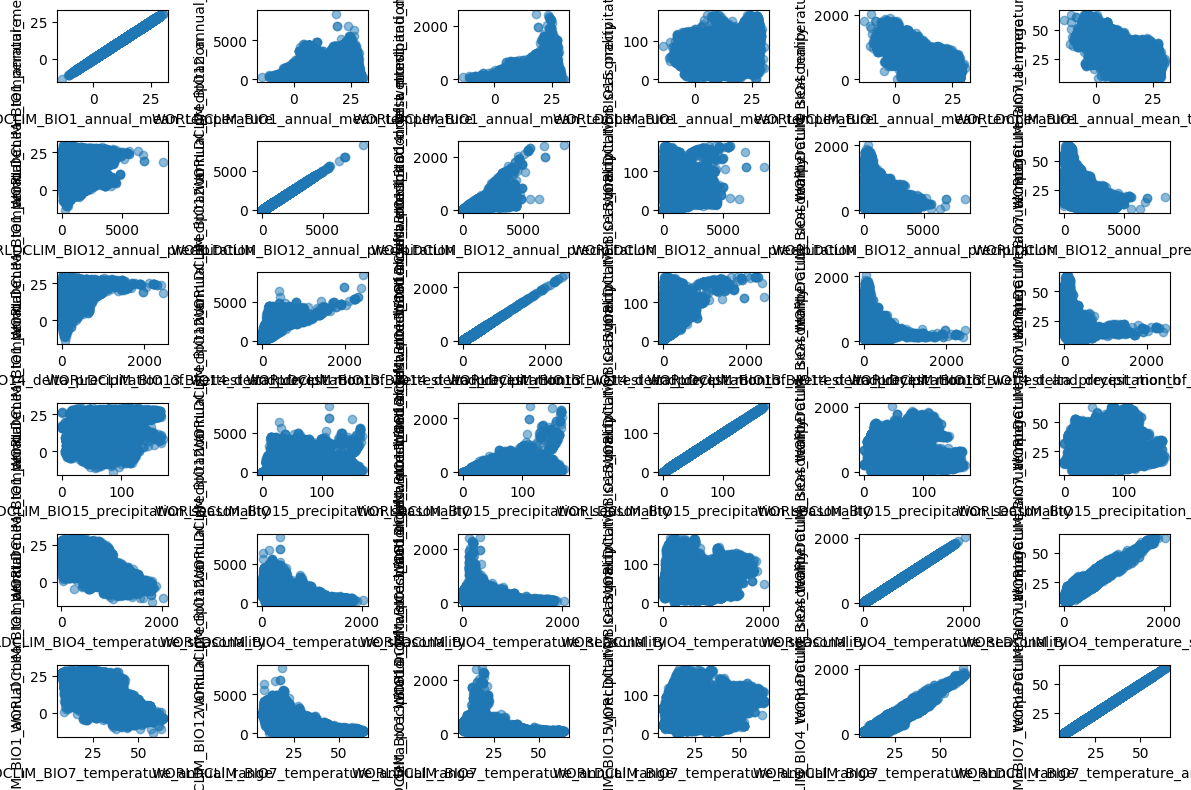

In [42]:
# Specify the columns for joint distribution
columns_for_joint_distribution = ['WORLDCLIM_BIO1_annual_mean_temperature', 'WORLDCLIM_BIO12_annual_precipitation', 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month', 'WORLDCLIM_BIO15_precipitation_seasonality', 'WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range']

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(column1)
        plt.ylabel(column2)
plt.tight_layout()
plt.show()


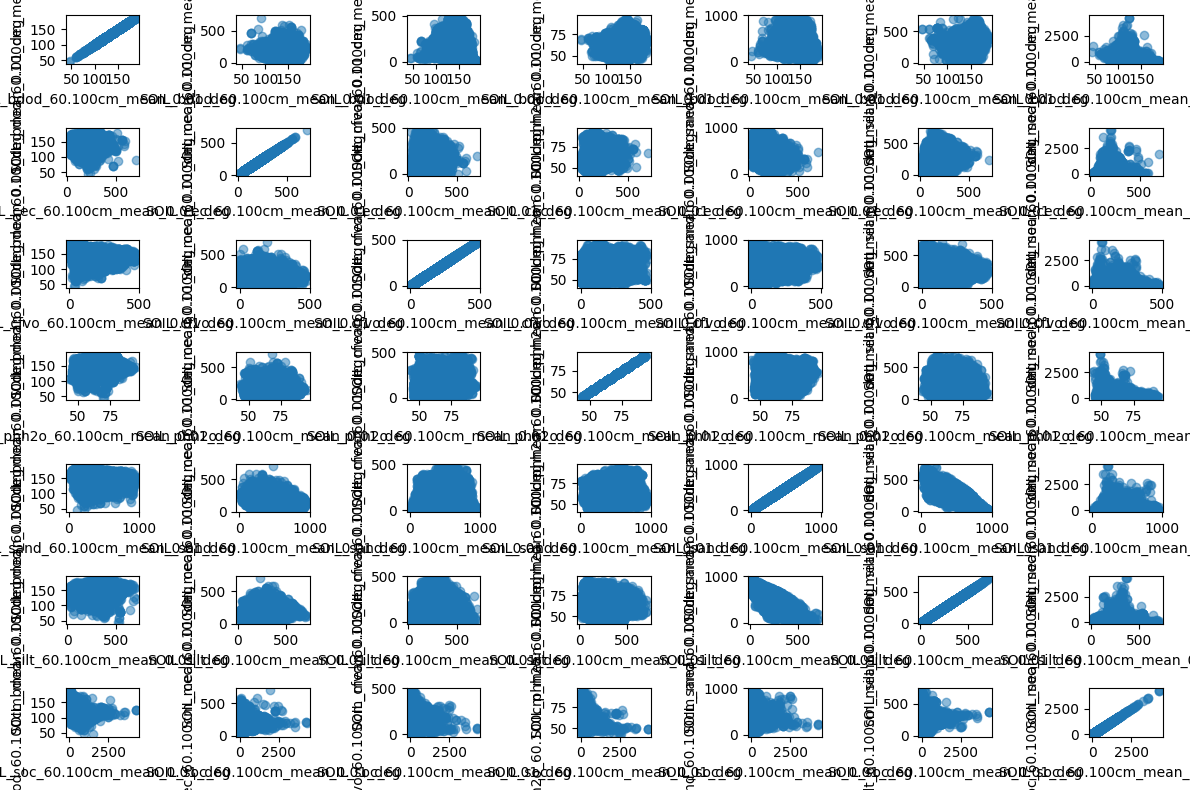

In [46]:
# Specify the columns for joint distribution
columns_for_joint_distribution = [
    'SOIL_bdod_60.100cm_mean_0.01_deg','SOIL_cec_60.100cm_mean_0.01_deg', 'SOIL_cfvo_60.100cm_mean_0.01_deg',
    #'SOIL_clay_60.100cm_mean_0.01_deg', 'SOIL_nitrogen_60.100cm_mean_0.01_deg', 'SOIL_ocd_60.100cm_mean_0.01_deg',
    'SOIL_phh2o_60.100cm_mean_0.01_deg', 'SOIL_sand_60.100cm_mean_0.01_deg','SOIL_silt_60.100cm_mean_0.01_deg',
    'SOIL_soc_60.100cm_mean_0.01_deg'
]

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(column1)
        plt.ylabel(column2)
plt.tight_layout()
plt.show()